In [388]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [389]:
frame = cv2.imread("C:\\Users\\dias_\\Desktop\\Testing\\test.png")
gray_image = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
blur_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
cannyed_image = cv2.Canny(blur_image, 100, 200)

In [390]:
cannyed_image.shape

(671, 1178)

In [391]:
def region_of_interest(image):
    height, width = image.shape
    mask = np.zeros_like(image)

    polygon = np.array([[
        (0, height* 8.8/10),
        (0, height * 8/10),
        (width /2, height * 1/3),
        (width, height * 8/10),
        (width, height* 8.8/10),
    ]], np.int32)

    cv2.fillPoly(mask, polygon, 255)
    cropped_image = cv2.bitwise_and(image, mask)
    return cropped_image

result = region_of_interest(cannyed_image)

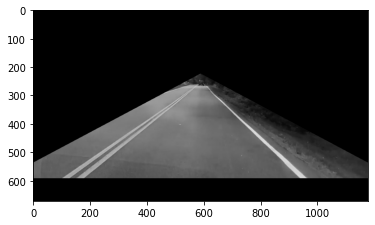

In [392]:
testing = region_of_interest(gray_image)
# plt.imshow(result)
plt.imshow(cv2.cvtColor(testing, cv2.COLOR_BGR2RGB))
plt.show()

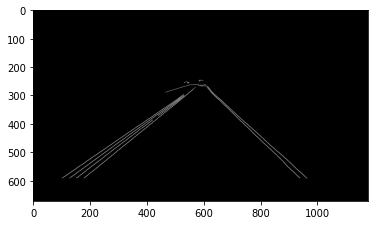

In [393]:
%matplotlib inline
# plt.imshow(result)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

# Testing 2: hough

In [394]:
def detect_lines(image):
    lines = cv2.HoughLinesP(
    image,
    rho=6,
    theta=np.pi / 60,
    threshold=200,
    lines=np.array([]),
    minLineLength=60,
    maxLineGap=20
    )
    return lines

lines = detect_lines(result)
# print(result_testing)

In [395]:
def draw_lines(img, lines, color=[0, 0, 255], thickness=10):
    # If there are no lines to draw, exit.
    if lines is None:
        return
    # Make a copy of the original image.
    img = np.copy(img)
    # Create a blank image that matches the original in size.
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )
    # Loop over all lines and draw them on the blank image.
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    # Merge the image with the lines onto the original.
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    # Return the modified image.
    return img

line_image = draw_lines(frame, lines)

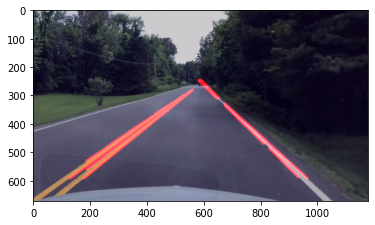

In [396]:
%matplotlib inline
# plt.imshow(result)
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.show()

# Creating a Single Left and Right Lane Line

In [397]:
left_line_x = []
left_line_y = []
right_line_x = []
right_line_y = []

for line in lines:
    for x1, y1, x2, y2 in line:
        slope = (y2 - y1) / (x2 - x1) # <-- Calculating the slope.
        if math.fabs(slope) < 0.5: # <-- Only consider extreme slope
            continue
        if slope <= 0: # <-- If the slope is negative, left group.
            left_line_x.extend([x1, x2])
            left_line_y.extend([y1, y2])
        else: # <-- Otherwise, right group.
            right_line_x.extend([x1, x2])
            right_line_y.extend([y1, y2])

In [398]:
min_y = int(frame.shape[0] * (3 / 5)) # <-- Just below the horizon
max_y = int(frame.shape[0] * (9.3 / 10)) # <-- The bottom of the image

In [399]:
poly_left = np.poly1d(np.polyfit(
    left_line_y,
    left_line_x,
    deg=1
))

left_x_start = int(poly_left(max_y))
left_x_end = int(poly_left(min_y))
poly_right = np.poly1d(np.polyfit(
    right_line_y,
    right_line_x,
    deg=1
))

right_x_start = int(poly_right(max_y))
right_x_end = int(poly_right(min_y))

In [400]:
line_image_updated = draw_lines(
    frame,
    [[
        [left_x_start, max_y, left_x_end, min_y],
        [right_x_start, max_y, right_x_end, min_y],
    ]],
    thickness=15,
)

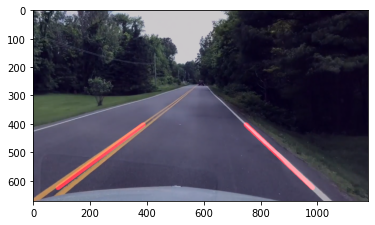

In [401]:
%matplotlib inline
# plt.imshow(result)
plt.imshow(cv2.cvtColor(line_image_updated, cv2.COLOR_BGR2RGB))
plt.show()

# Calculate Steering Angle

In [402]:
added_lines = [[
        [left_x_start, max_y, left_x_end, min_y],
        [right_x_start, max_y, right_x_end, min_y],
    ]]

height, width = cannyed_image.shape
left_x2 = left_x_end
right_x2 = right_x_end
mid = int(width / 2)
x_offset = (left_x2 + right_x2) / 2 - mid
y_offset = int(height / 2)

angle_to_mid_radian = math.atan(x_offset / y_offset)  # angle (in radian) to center vertical line
angle_to_mid_deg = int(angle_to_mid_radian * 180.0 / math.pi)  # angle (in degrees) to center vertical line
steering_angle = angle_to_mid_deg + 90  # this is the steering angle needed by picar front wheel

steering_angle

87